In [ ]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import statsmodels.tsa.api as smt
from scipy.stats import boxcox



In [ ]:
sales = pd.read_csv('Weekly sales for a novelty item p3738 Montgomery.csv', index_col=0)
sales['x'] = sales['x'].fillna(sales['x'].mean())
sales.isnull().sum()
df = sales

In [ ]:

df.describe()

,x
count,65.000000
mean,63.846154
std,13.891579
min,35.000000
25%,51.000000
50%,64.000000
75%,76.000000
max,94.000000


In [ ]:

df.head()

,x
1,35
2,46
3,51
4,46
5,48


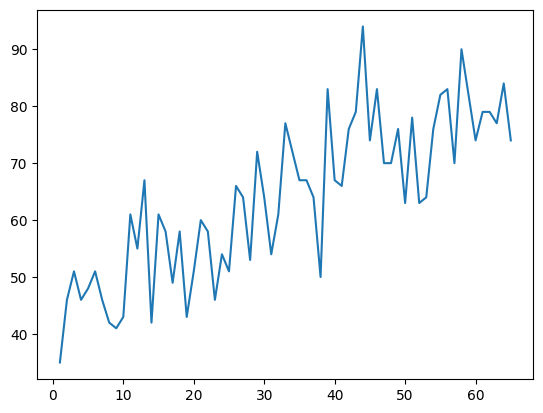

In [ ]:

plt.plot(sales['x'])

In [ ]:
from statsmodels.tsa.stattools import adfuller

def df_test(name: str, df: pd.Series) -> None:
    alpha = 0.05
    name = name
    ts = df
    print(f"Тест Дики-Фуллера ряда {name}:")
    dftest = adfuller(ts, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Users', 'Number of Observations Used'])

    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    if dfoutput["p-value"] < alpha:
        print(f"Значение p меньше {alpha*100}%. Ряд стационарный.")
    else:
        print(f"Значение p больше {alpha*100}%. Ряд не стационарный.")

In [ ]:

df_test('Продажи', df['x'])

Тест Дики-Фуллера ряда Продажи:
Test Statistic                 -1.587648
p-value                         0.489795
#Lags Users                     2.000000
Number of Observations Used    62.000000
Critical Value (1%)            -3.540523
Critical Value (5%)            -2.909427
Critical Value (10%)           -2.592314
dtype: float64
Значение p больше 5.0%. Ряд не стационарный.


In [ ]:
nottrend = []
s = 6
notseason = []

# выборка без тренда
for i in range(1, len(df['x'])):
    nottrend.append(df['x'].iloc[i] - df['x'].iloc[i-1])

# выборка без сезонности
for i in range(s, len(df['x'])):
    notseason.append(df['x'].iloc[i] - df['x'].iloc[i-s])

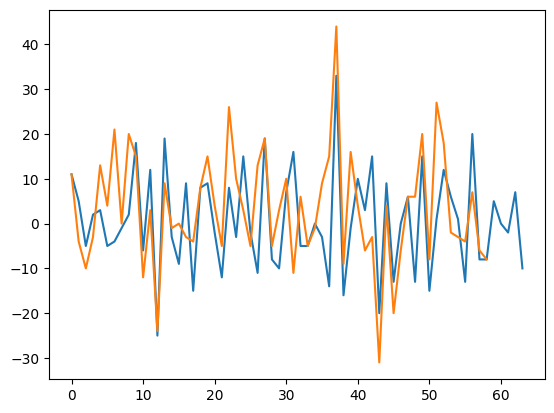

In [ ]:
plt.plot(nottrend)
plt.plot(notseason)

In [ ]:


df_test('Не тренд', notseason)

Тест Дики-Фуллера ряда Не тренд:
Test Statistic                 -5.536296
p-value                         0.000002
#Lags Users                     5.000000
Number of Observations Used    53.000000
Critical Value (1%)            -3.560242
Critical Value (5%)            -2.917850
Critical Value (10%)           -2.596796
dtype: float64
Значение p меньше 5.0%. Ряд стационарный.


In [ ]:

min_value = np.min(df['x'])
shifted_data = df['x'] - min_value + 1


transformed_data, best_lambda = boxcox(shifted_data)

print(best_lambda)


0.8441490358483813


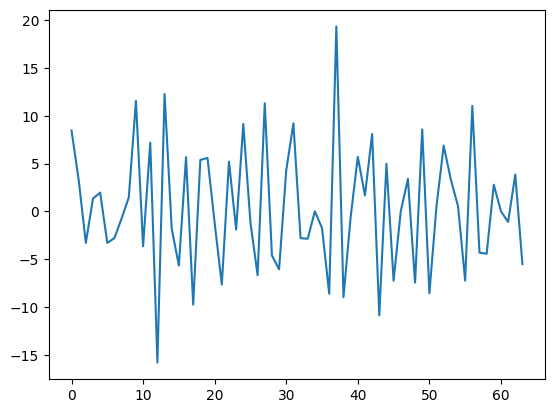

In [14]:
pnottrend = []

for i in range(1, len(transformed_data)):
    pnottrend.append(transformed_data[i] - transformed_data[i-1])

plt.plot(pnottrend)

In [15]:
df_test('Бокс-Кокс', pnottrend)

Тест Дики-Фуллера ряда Бокс-Кокс:
Test Statistic                -6.348671e+00
p-value                        2.643940e-08
#Lags Users                    3.000000e+00
Number of Observations Used    6.000000e+01
Critical Value (1%)           -3.544369e+00
Critical Value (5%)           -2.911073e+00
Critical Value (10%)          -2.593190e+00
dtype: float64
Значение p меньше 5.0%. Ряд стационарный.


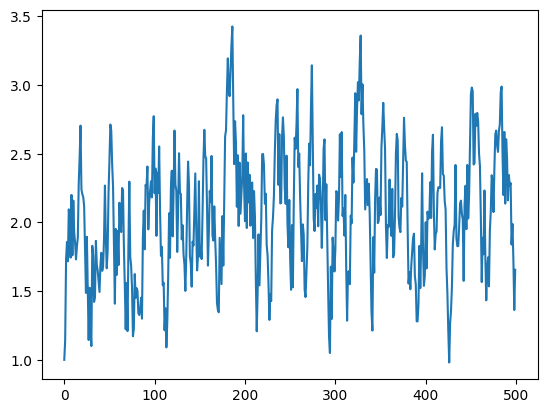

In [16]:
# AR(1)

N = 500

ar1 = [1]
ar1_minus = [1]
ar3 = [1]
for i in range(1, N):
    ar1.append(0.76 * ar1[i-1] + np.random.random())
    ar1_minus.append(-0.76 * ar1_minus[i-1] + np.random.random())
    ar3.append(2 * ar3[i-1] + np.random.random())



plt.plot(ar1)

In [17]:
print(f"standart deviation = {np.std(ar1)}\nmean = {np.mean(ar1)}")

standart deviation = 0.45168648918278503
mean = 2.0636012614067414


In [18]:
def plot_ar1(name: list) -> None:
    ts = pd.DataFrame(name)

    fig = plt.figure(figsize=(20, 9))
    layout = (2, 2)
    ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
    acf_ax = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 1))

    ts.plot(ax=ts_ax)
    ts_ax.set_title('Time Series Analysis Plots')
    smt.graphics.plot_acf(ts, lags=20, ax=acf_ax, alpha=0.5)
    smt.graphics.plot_pacf(ts, lags=20, ax=pacf_ax, alpha=0.5)

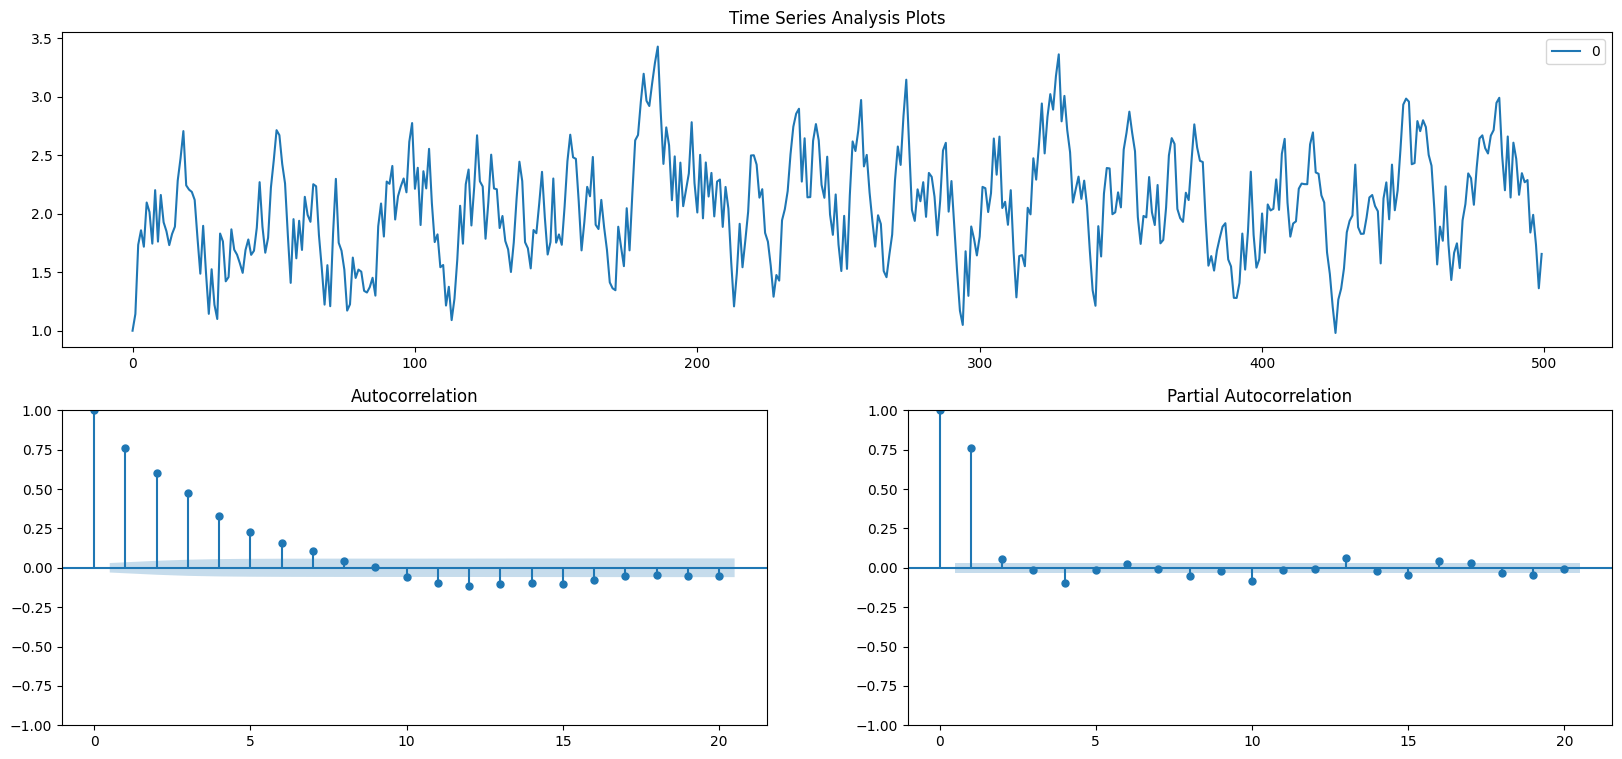

In [19]:

plot_ar1(ar1)

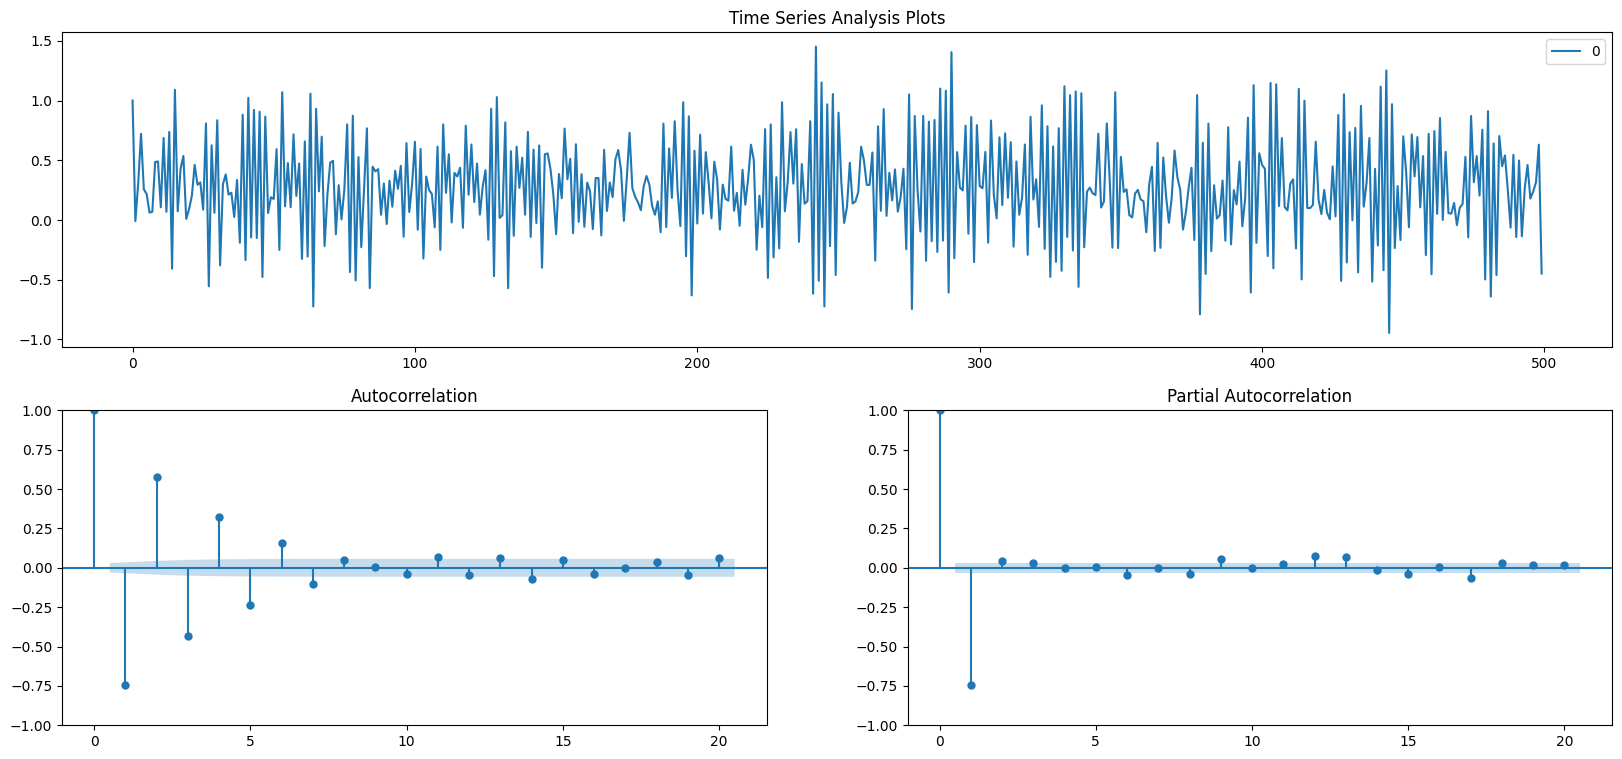

In [20]:
plot_ar1(ar1_minus)

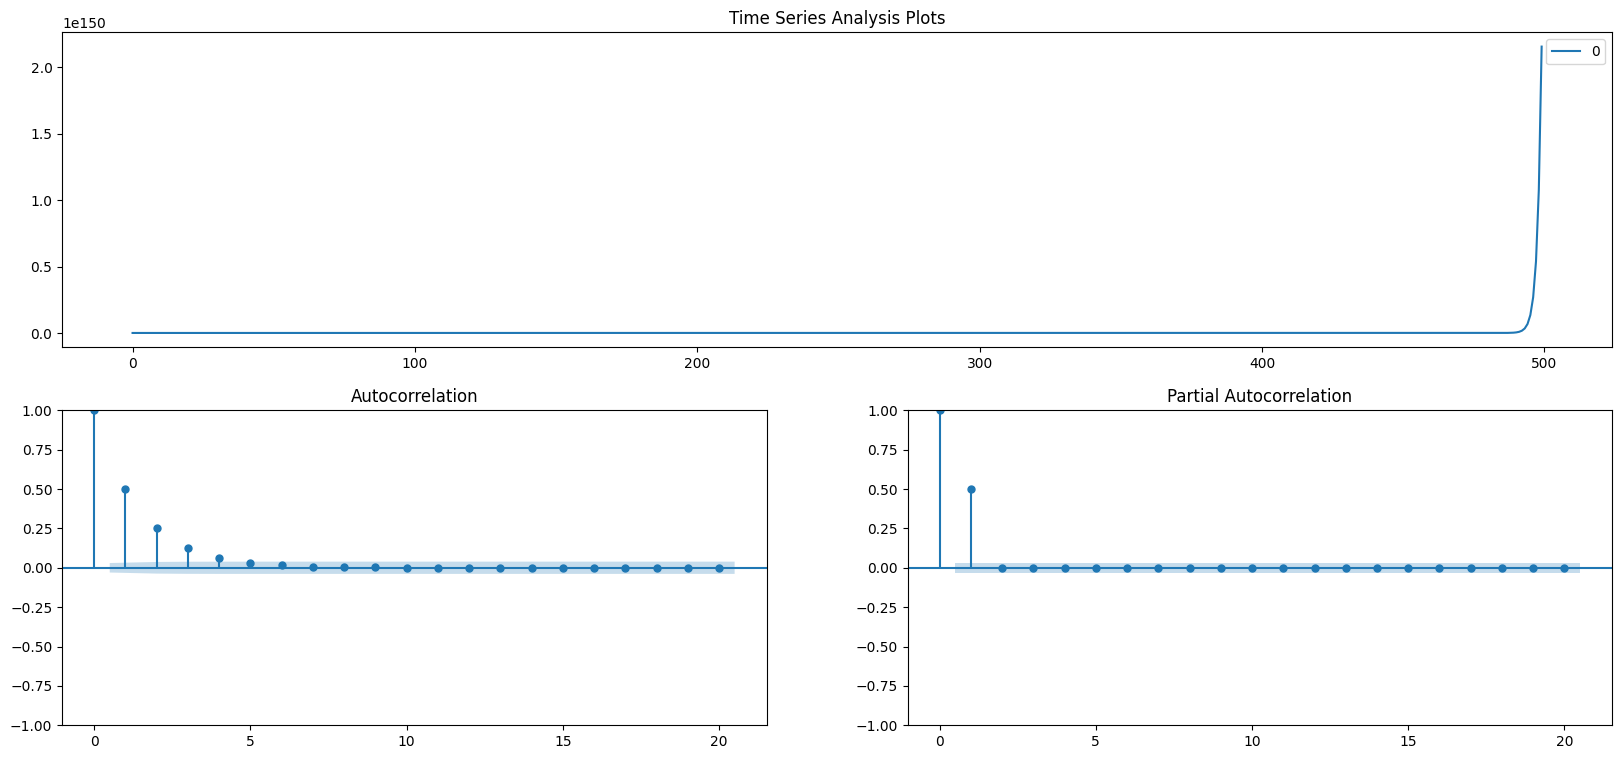

In [21]:

plot_ar1(ar3)

In [22]:
df = pd.read_csv('Weekly sales for a novelty item p3738 Montgomery.csv',
                 names=['n', 'x'], skiprows=1)
df['x'] = df['x'].fillna(df['x'].mean())

df['t'] = df.index.values

ln = len(df)

# указываем 'объёмы' выборок
train_cutoff = int(round(ln * 0.75, 0))
validate_cutoff = int(round(ln * 0.90, 0))

# делим выборки
train_df = df[df['t'] <= train_cutoff]
validate_df = df[(df['t'] > train_cutoff) & (df['t'] <= validate_cutoff)]
forecast_df = df[df['t'] > validate_cutoff]

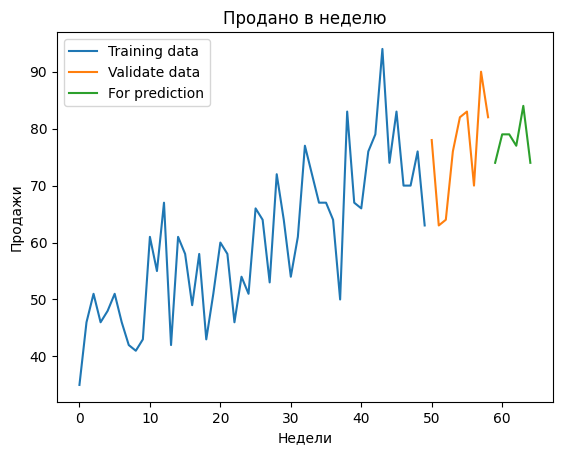

In [33]:
plt.plot(train_df.t, train_df.x, label='Training data')
plt.plot(validate_df.t, validate_df.x, label='Validate data')
plt.plot(forecast_df.t, forecast_df.x, label='For prediction')
plt.legend()
plt.title('Продано в неделю')
plt.ylabel('Продажи')
plt.xlabel('Недели')
plt.show()

In [24]:

from statsmodels.tsa.ar_model import AutoReg, ar_select_order


mod = AutoReg(df.t, 3, old_names=False)
res = mod.fit()

print(res.summary())

                            AutoReg Model Results                             
Dep. Variable:                      t   No. Observations:                   65
Model:                     AutoReg(3)   Log Likelihood                1901.493
Method:               Conditional MLE   S.D. of innovations              0.000
Date:                Thu, 09 Nov 2023   AIC                          -3792.986
Time:                        18:41:03   BIC                          -3782.350
Sample:                             3   HQIC                         -3788.810
                                   65                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6667   9.77e-16   6.82e+14      0.000       0.667       0.667
t.L1           1.0000   9.54e-16   1.05e+15      0.000       1.000       1.000
t.L2           0.3333    2.7e-17   1.24e+16      0.0

In [25]:

sel = ar_select_order(df.x, 13, old_names=False)
sel.ar_lags
res = sel.model.fit()
print(res.summary())


                            AutoReg Model Results                             
Dep. Variable:                      x   No. Observations:                   65
Model:                     AutoReg(3)   Log Likelihood                -222.513
Method:               Conditional MLE   S.D. of innovations              8.758
Date:                Thu, 09 Nov 2023   AIC                            455.027
Time:                        18:41:11   BIC                            465.662
Sample:                             3   HQIC                           459.202
                                   65                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         10.8980      6.111      1.783      0.075      -1.080      22.876
x.L1           0.2388      0.121      1.977      0.048       0.002       0.476
x.L2           0.3071      0.120      2.570      0.0

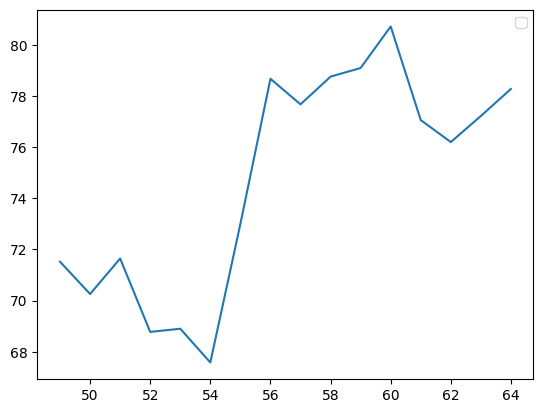

In [26]:
# смотрим предсказание
fig = res.plot_predict(train_cutoff)

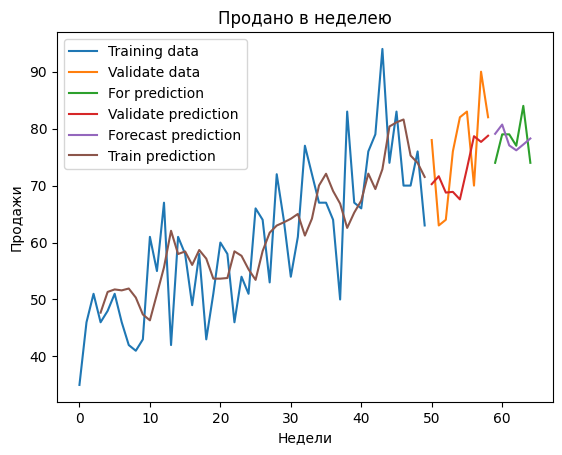

In [32]:

pred = res.predict(start=0, end=train_cutoff, dynamic=False)
v_pred = res.predict(start=train_cutoff+1, end=(validate_cutoff), dynamic=False)
f_pred = res.predict(start=validate_cutoff+1, end=(forecast_df.t[len(df.t) - 1]), dynamic=False)


plt.plot(train_df.t, train_df.x, label='Training data')
plt.plot(validate_df.t, validate_df.x, label='Validate data')
plt.plot(forecast_df.t, forecast_df.x, label='For prediction')
plt.plot(validate_df.t, v_pred, label='Validate prediction')
plt.plot(forecast_df.t, f_pred, label='Forecast prediction')
plt.plot(train_df.t, pred, label='Train prediction')

plt.legend()
plt.title('Продано в неделею')
plt.ylabel('Продажи')
plt.xlabel('Недели')
plt.show()

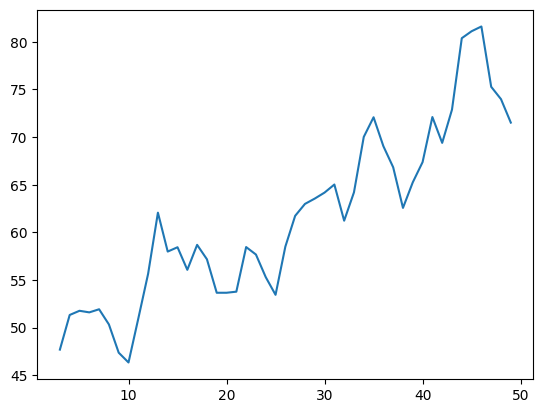

In [30]:

plt.plot(pred)

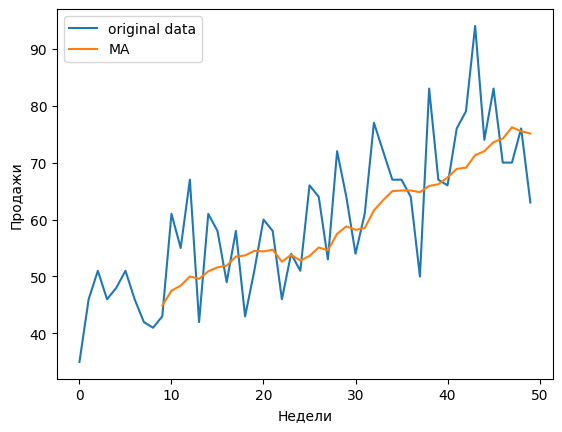

In [31]:
# MA

df['t'] = df.index.values

ln = len(df)

# указываем 'объемы' выборок
train_cutoff = int(round(ln*0.75, 0))
validate_cutoff = int(round(ln*0.90,0))

# делим выборки
train_df = df[df['t'] <= train_cutoff]
validate_df = df[(df['t'] > train_cutoff) & (df['t'] <= validate_cutoff)]
forecast_df = df[df['t'] > validate_cutoff]

plt.plot(train_df["t"], train_df["x"], label="original data")
plt.plot(train_df["t"], train_df["x"].rolling(10).mean(), label="MA")
plt.legend()
plt.ylabel('Продажи')
plt.xlabel('Недели')
plt.show()


In [34]:
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error, r2_score


print("RMSE:", np.sqrt(mean_squared_error(forecast_df.x, f_pred)))
print("MAPE:", mean_absolute_percentage_error(forecast_df.x, f_pred))
print("MAE:", mean_absolute_error(forecast_df.x, f_pred))
print("R2: ", r2_score(forecast_df.x, f_pred))


RMSE: 4.033139420779629
MAPE: 0.04401713248102848
MAE: 3.43562680646005
R2:  -0.37784397446606866
